Copyright 2021 Takehiro Ajioka

### Enviroment

Python 3.6
Anaconda
tensorflow-gpu==1.15.0
keras==2.3.1
shap==0.36.0
tfdeterminism==0.3.0

In [1]:
# Ignore warning
import os
import tensorflow as tf
import logging
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

In [2]:
import numpy
import pandas
import matplotlib.pyplot as plt
from scipy import io
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, ConvLSTM2D, Bidirectional
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

In [3]:
# Allow grouth option of GPU
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [4]:
# Load data
signal = io.loadmat('../data/signal_5mice.mat')
runrest = io.loadmat('../data/runrest_5mice.mat')

In [5]:
plt.rcParams["font.size"] = 18

# Preprocess

In [6]:
# Mini-max normalization
def mini_max(dataset):
    min_value = dataset.min(axis=0)
    max_value = dataset.max(axis=0)
    dataset_nor = (dataset - min_value) / (max_value - min_value)
    return dataset_nor

In [7]:
# Create input data [-n,n+1]
def create_dataset(dataset, look_frame):
    dataX, dataY = [], []
    for i in range(look_frame,len(dataset)-(look_frame)):
        xset = []
        for j in range(dataset.shape[1]-1):
            a = dataset[(i-look_frame):(i+look_frame+1), j]
            xset.append(a)
        dataY.append(dataset[i, -1])      
        dataX.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

In [8]:
# look_frame = 15 #read the previous and next n frames as input

def Data_preprocess(signal, runrest, look_frame):
    # Normalize
    signal = mini_max(signal.transpose())
    runrest = runrest.transpose()
    # Create dataset
    dataset = numpy.hstack([signal.astype('float32'), runrest.astype('float32')])
    X, Y = create_dataset(dataset, look_frame)
    return X, Y

In [9]:
def Get_Dataset(TEST, look_frame):
    print('TEST')
    # Test dataset
    testX = numpy.empty([0,50,2*look_frame+1], dtype=numpy.float32)
    testY = numpy.empty(0, dtype=numpy.float32)
    for i in TEST:
        print(f'Mouse {i}')
        for j in range(signal['signal'+str(i)].shape[1]):
            X, Y = Data_preprocess(signal['signal'+str(i)][0,j], runrest['runrest'+str(i)][0,j], look_frame)
            testX = numpy.concatenate([testX, X], axis=0)
            testY = numpy.concatenate([testY, Y], axis=0)

    return testX, testY

# Evaluate

In [10]:
import itertools

In [11]:
LookFrame = [5, 10, 15, 20, 25, 30]
ModelType = 'GRU'

In [12]:
# Plot ROC curve
def plot_roc(y_pred, y_test, mode):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    AUC = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
    plt.title(mode + " ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    print('AUC: {:.3f}'.format(AUC))
    opt_thr = thresholds[numpy.argmax(tpr - fpr)]
    print('Optimal threshold: {:.3f}'.format(opt_thr))
    return AUC

In [13]:
df_AUC = pandas.DataFrame(numpy.zeros([20, 8]), columns=['VALID','TEST']+LookFrame)
df_LOSS = pandas.DataFrame(numpy.zeros([20, 8]), columns=['VALID','TEST']+LookFrame)
df_ACC = pandas.DataFrame(numpy.zeros([20, 8]), columns=['VALID','TEST']+LookFrame)

TEST
Mouse 1
(197890, 50, 11)


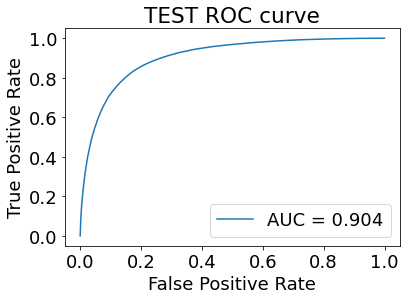

AUC: 0.904
Optimal threshold: 0.295
197890/197890 [==============================] - 31s 158us/sample - loss: 0.3855 - acc: 0.8333
TEST
Mouse 1
(197780, 50, 21)


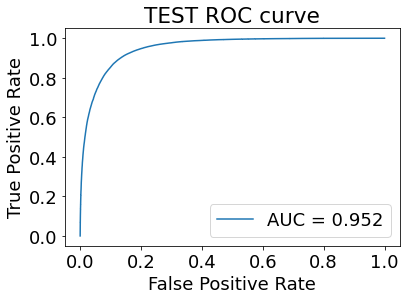

AUC: 0.952
Optimal threshold: 0.111
197780/197780 [==============================] - 37s 185us/sample - loss: 0.3393 - acc: 0.8494
TEST
Mouse 1
(197670, 50, 31)


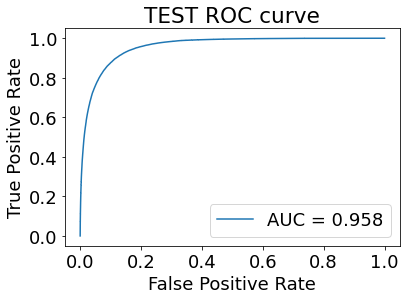

AUC: 0.958
Optimal threshold: 0.316
197670/197670 [==============================] - 44s 221us/sample - loss: 0.2553 - acc: 0.8914
TEST
Mouse 1
(197560, 50, 41)


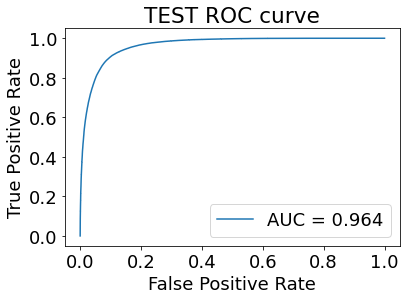

AUC: 0.964
Optimal threshold: 0.191
197560/197560 [==============================] - 53s 268us/sample - loss: 0.2614 - acc: 0.8853
TEST
Mouse 1
(197450, 50, 51)


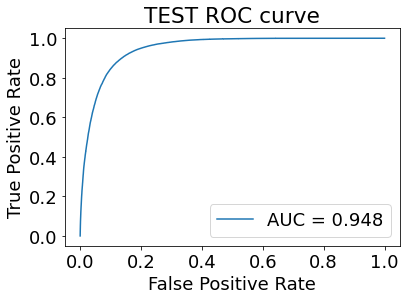

AUC: 0.948
Optimal threshold: 0.325
197450/197450 [==============================] - 62s 315us/sample - loss: 0.3077 - acc: 0.8798
TEST
Mouse 1
(197340, 50, 61)


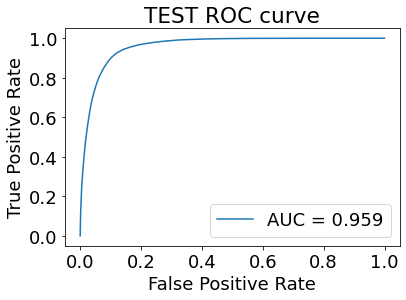

AUC: 0.959
Optimal threshold: 0.152
197340/197340 [==============================] - 72s 363us/sample - loss: 0.2747 - acc: 0.8915
TEST
Mouse 1
(197890, 50, 11)


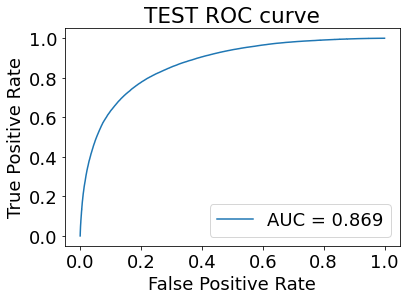

AUC: 0.869
Optimal threshold: 0.287
197890/197890 [==============================] - 36s 180us/sample - loss: 0.4692 - acc: 0.8029
TEST
Mouse 1
(197780, 50, 21)


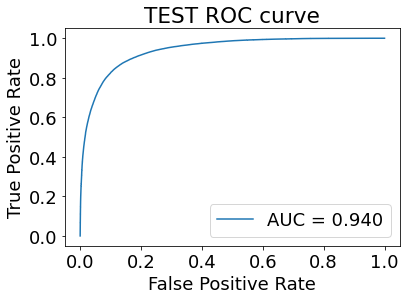

AUC: 0.940
Optimal threshold: 0.147
197780/197780 [==============================] - 38s 192us/sample - loss: 0.3575 - acc: 0.8512
TEST
Mouse 1
(197670, 50, 31)


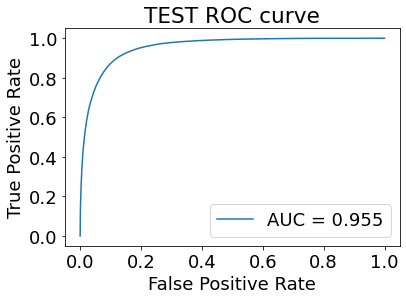

AUC: 0.955
Optimal threshold: 0.109
197670/197670 [==============================] - 44s 224us/sample - loss: 0.3364 - acc: 0.8531
TEST
Mouse 1
(197560, 50, 41)


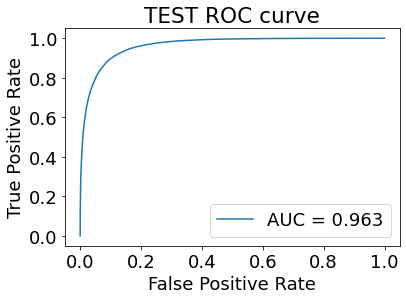

AUC: 0.963
Optimal threshold: 0.111
197560/197560 [==============================] - 54s 274us/sample - loss: 0.3228 - acc: 0.8636
TEST
Mouse 1
(197450, 50, 51)


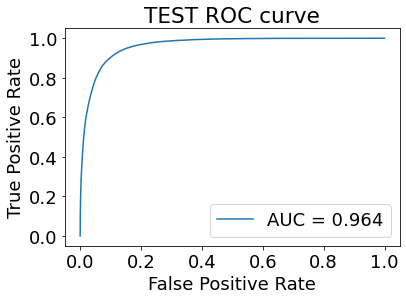

AUC: 0.964
Optimal threshold: 0.131
197450/197450 [==============================] - 63s 320us/sample - loss: 0.2733 - acc: 0.8834
TEST
Mouse 1
(197340, 50, 61)


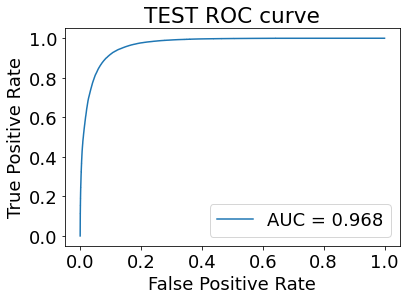

AUC: 0.968
Optimal threshold: 0.170
197340/197340 [==============================] - 72s 367us/sample - loss: 0.2499 - acc: 0.8920
TEST
Mouse 1
(197890, 50, 11)


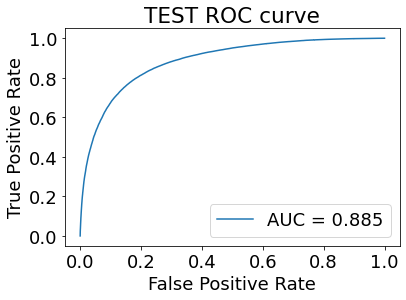

AUC: 0.885
Optimal threshold: 0.249
197890/197890 [==============================] - 27s 138us/sample - loss: 0.4410 - acc: 0.8135
TEST
Mouse 1
(197780, 50, 21)


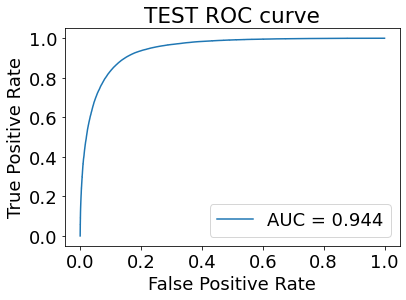

AUC: 0.944
Optimal threshold: 0.137
197780/197780 [==============================] - 38s 190us/sample - loss: 0.3381 - acc: 0.8530
TEST
Mouse 1
(197670, 50, 31)


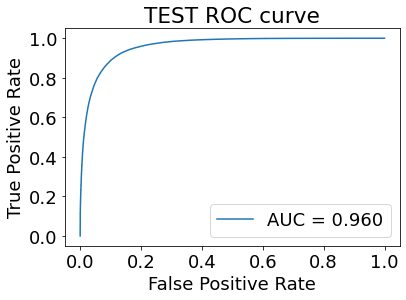

AUC: 0.960
Optimal threshold: 0.104
197670/197670 [==============================] - 45s 230us/sample - loss: 0.3264 - acc: 0.8559
TEST
Mouse 1
(197560, 50, 41)


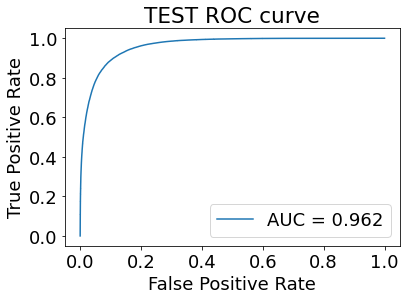

AUC: 0.962
Optimal threshold: 0.112
197560/197560 [==============================] - 53s 270us/sample - loss: 0.3190 - acc: 0.8626
TEST
Mouse 1
(197450, 50, 51)


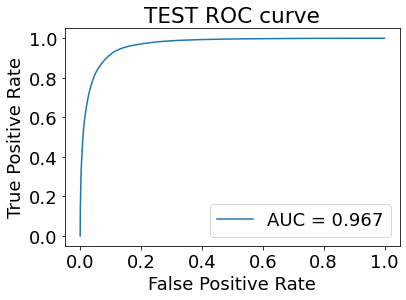

AUC: 0.967
Optimal threshold: 0.125
197450/197450 [==============================] - 64s 323us/sample - loss: 0.2629 - acc: 0.8901
TEST
Mouse 1
(197340, 50, 61)


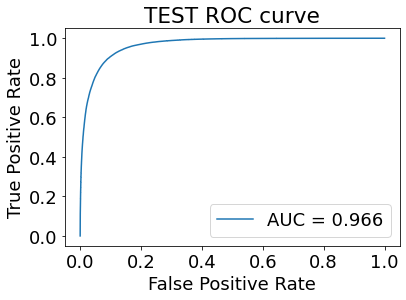

AUC: 0.966
Optimal threshold: 0.138
197340/197340 [==============================] - 73s 368us/sample - loss: 0.2668 - acc: 0.8840
TEST
Mouse 1
(197890, 50, 11)


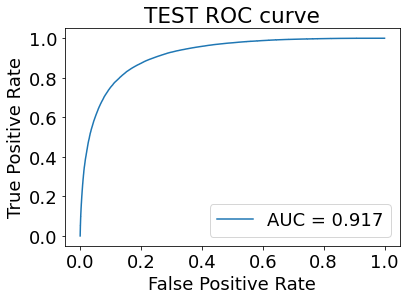

AUC: 0.917
Optimal threshold: 0.267
197890/197890 [==============================] - 38s 194us/sample - loss: 0.3665 - acc: 0.8423
TEST
Mouse 1
(197780, 50, 21)


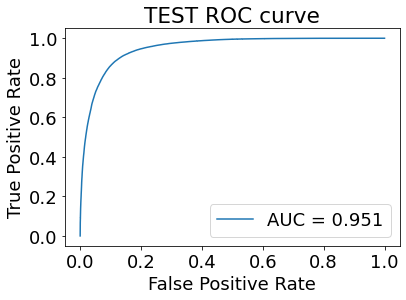

AUC: 0.951
Optimal threshold: 0.089
197780/197780 [==============================] - 39s 199us/sample - loss: 0.3750 - acc: 0.8324
TEST
Mouse 1
(197670, 50, 31)


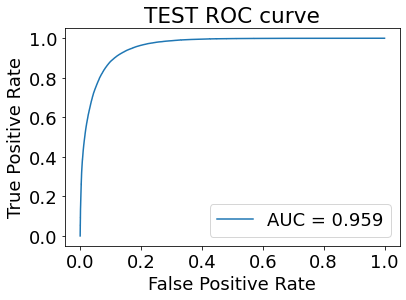

AUC: 0.959
Optimal threshold: 0.073
197670/197670 [==============================] - 46s 231us/sample - loss: 0.3449 - acc: 0.8524
TEST
Mouse 1
(197560, 50, 41)


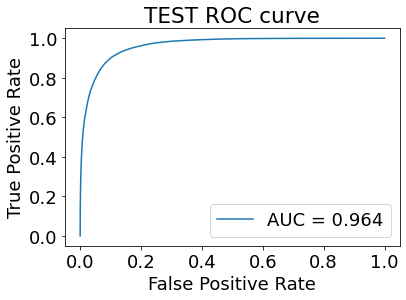

AUC: 0.964
Optimal threshold: 0.083
197560/197560 [==============================] - 54s 275us/sample - loss: 0.3251 - acc: 0.8719
TEST
Mouse 1
(197450, 50, 51)


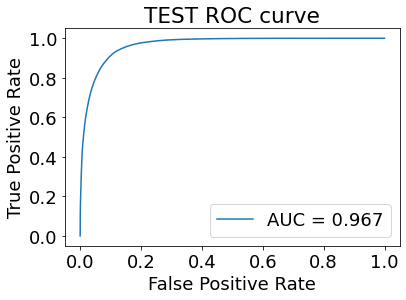

AUC: 0.967
Optimal threshold: 0.116
197450/197450 [==============================] - 64s 324us/sample - loss: 0.2771 - acc: 0.8760
TEST
Mouse 1
(197340, 50, 61)


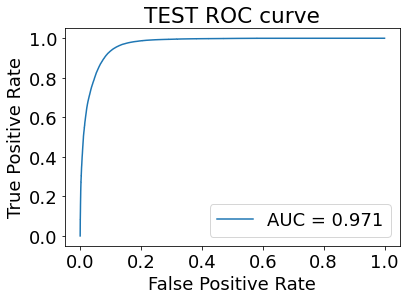

AUC: 0.971
Optimal threshold: 0.098
197340/197340 [==============================] - 73s 371us/sample - loss: 0.2541 - acc: 0.8917
TEST
Mouse 2
(215880, 50, 11)


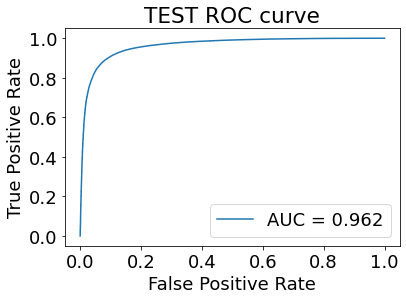

AUC: 0.962
Optimal threshold: 0.407
215880/215880 [==============================] - 44s 205us/sample - loss: 0.2856 - acc: 0.8881
TEST
Mouse 2
(215760, 50, 21)


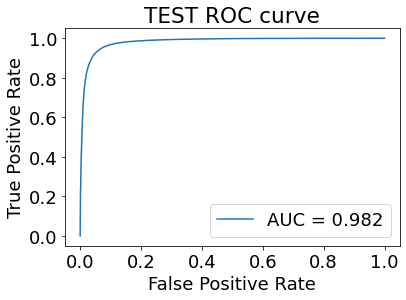

AUC: 0.982
Optimal threshold: 0.587
215760/215760 [==============================] - 43s 201us/sample - loss: 0.1587 - acc: 0.9439
TEST
Mouse 2
(215640, 50, 31)


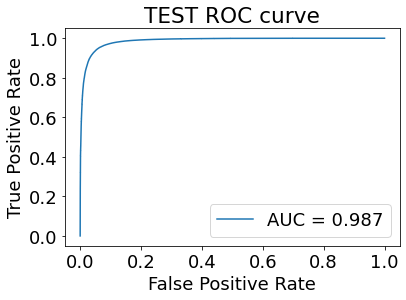

AUC: 0.987
Optimal threshold: 0.551
215640/215640 [==============================] - 51s 237us/sample - loss: 0.1443 - acc: 0.9485
TEST
Mouse 2
(215520, 50, 41)


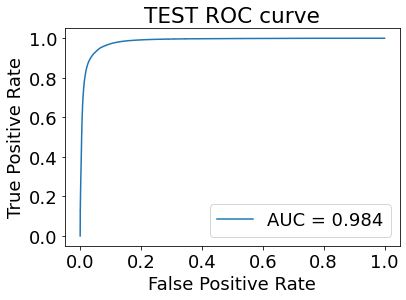

AUC: 0.984
Optimal threshold: 0.595
215520/215520 [==============================] - 60s 280us/sample - loss: 0.1442 - acc: 0.9470
TEST
Mouse 2
(215400, 50, 51)


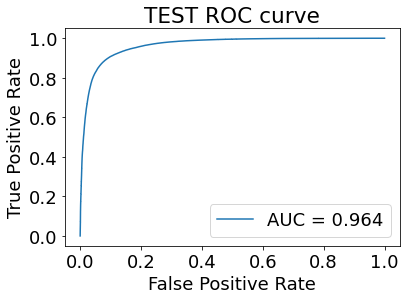

AUC: 0.964
Optimal threshold: 0.557
215400/215400 [==============================] - 70s 326us/sample - loss: 0.2581 - acc: 0.9060
TEST
Mouse 2
(215280, 50, 61)


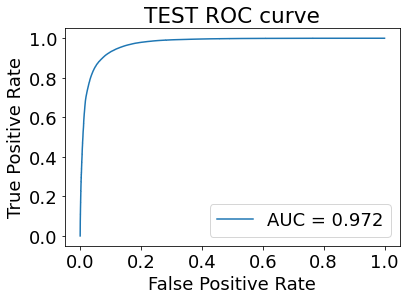

AUC: 0.972
Optimal threshold: 0.433
215280/215280 [==============================] - 80s 373us/sample - loss: 0.2223 - acc: 0.9136
TEST
Mouse 2
(215880, 50, 11)


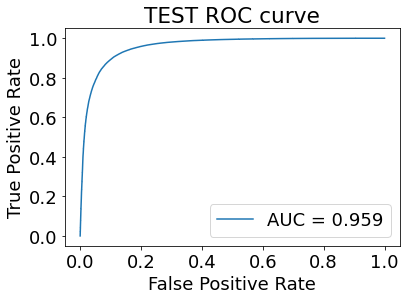

AUC: 0.959
Optimal threshold: 0.214
215880/215880 [==============================] - 41s 189us/sample - loss: 0.3593 - acc: 0.8562
TEST
Mouse 2
(215760, 50, 21)


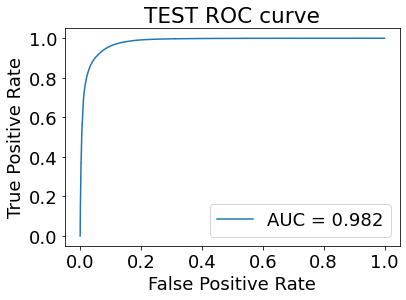

AUC: 0.982
Optimal threshold: 0.348
215760/215760 [==============================] - 47s 216us/sample - loss: 0.1866 - acc: 0.9270
TEST
Mouse 2
(215640, 50, 31)


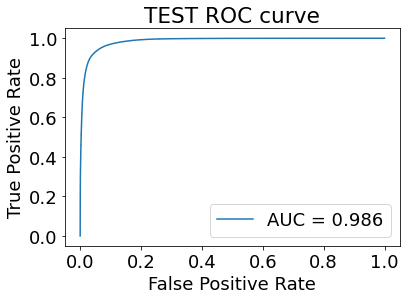

AUC: 0.986
Optimal threshold: 0.439
215640/215640 [==============================] - 51s 238us/sample - loss: 0.1625 - acc: 0.9404
TEST
Mouse 2
(215520, 50, 41)


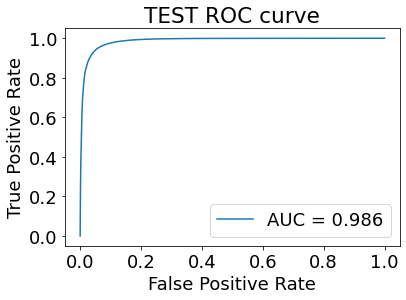

AUC: 0.986
Optimal threshold: 0.495
215520/215520 [==============================] - 62s 286us/sample - loss: 0.1453 - acc: 0.9468
TEST
Mouse 2
(215400, 50, 51)


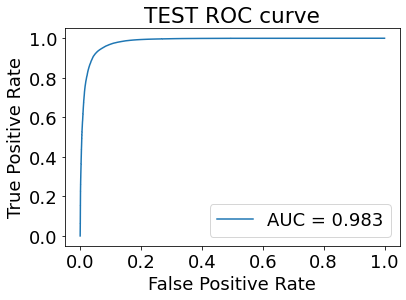

AUC: 0.983
Optimal threshold: 0.494
215400/215400 [==============================] - 71s 331us/sample - loss: 0.1696 - acc: 0.9394
TEST
Mouse 2
(215280, 50, 61)


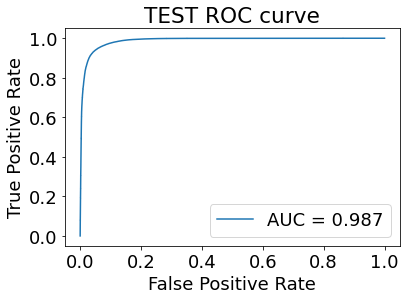

AUC: 0.987
Optimal threshold: 0.725
215280/215280 [==============================] - 82s 380us/sample - loss: 0.1308 - acc: 0.9501
TEST
Mouse 2
(215880, 50, 11)


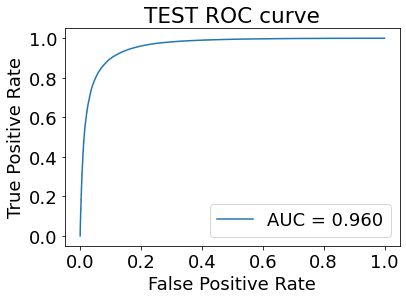

AUC: 0.960
Optimal threshold: 0.236
215880/215880 [==============================] - 46s 212us/sample - loss: 0.3538 - acc: 0.8562
TEST
Mouse 2
(215760, 50, 21)


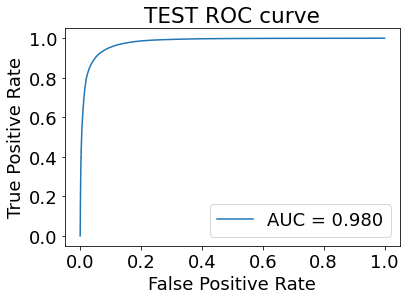

AUC: 0.980
Optimal threshold: 0.376
215760/215760 [==============================] - 46s 214us/sample - loss: 0.1976 - acc: 0.9261
TEST
Mouse 2
(215640, 50, 31)


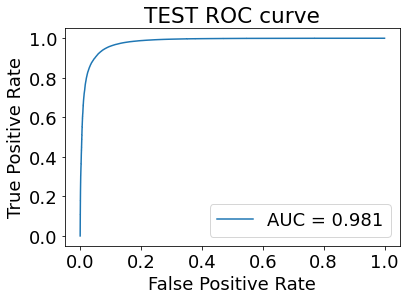

AUC: 0.981
Optimal threshold: 0.363
215640/215640 [==============================] - 52s 243us/sample - loss: 0.1944 - acc: 0.9239
TEST
Mouse 2
(215520, 50, 41)


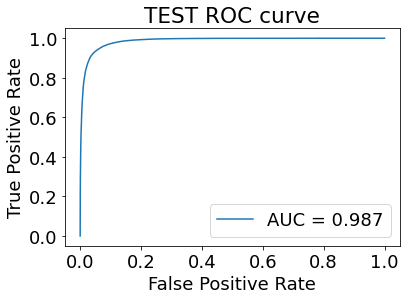

AUC: 0.987
Optimal threshold: 0.543
215520/215520 [==============================] - 62s 290us/sample - loss: 0.1451 - acc: 0.9456
TEST
Mouse 2
(215400, 50, 51)


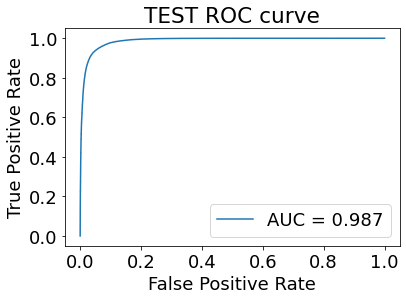

AUC: 0.987
Optimal threshold: 0.593
215400/215400 [==============================] - 73s 338us/sample - loss: 0.1336 - acc: 0.9488
TEST
Mouse 2
(215280, 50, 61)


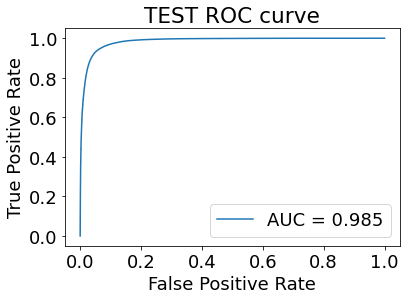

AUC: 0.985
Optimal threshold: 0.698
215280/215280 [==============================] - 82s 381us/sample - loss: 0.1505 - acc: 0.9463
TEST
Mouse 2
(215880, 50, 11)


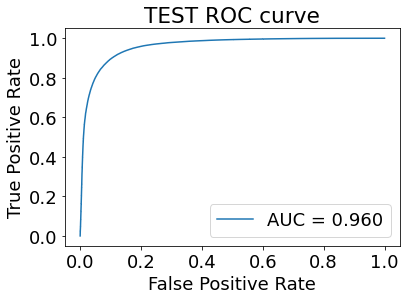

AUC: 0.960
Optimal threshold: 0.314
215880/215880 [==============================] - 52s 242us/sample - loss: 0.3108 - acc: 0.8819
TEST
Mouse 2
(215760, 50, 21)


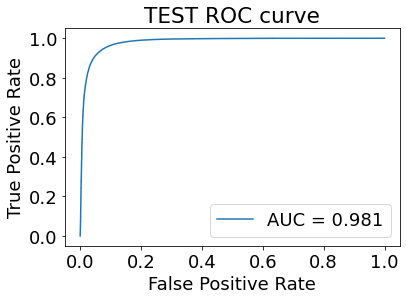

AUC: 0.981
Optimal threshold: 0.430
215760/215760 [==============================] - 48s 221us/sample - loss: 0.1774 - acc: 0.9339
TEST
Mouse 2
(215640, 50, 31)


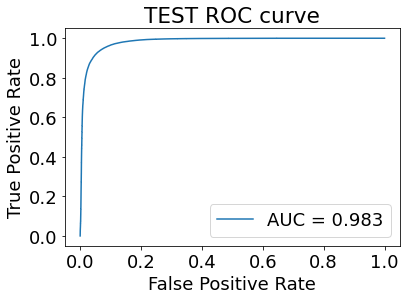

AUC: 0.983
Optimal threshold: 0.435
215640/215640 [==============================] - 54s 250us/sample - loss: 0.1713 - acc: 0.9353
TEST
Mouse 2
(215520, 50, 41)


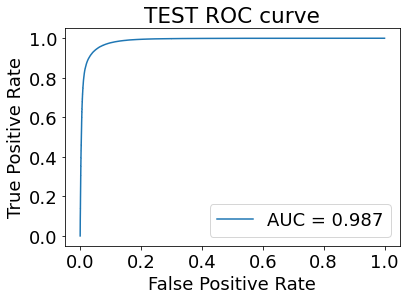

AUC: 0.987
Optimal threshold: 0.385
215520/215520 [==============================] - 63s 292us/sample - loss: 0.1560 - acc: 0.9422
TEST
Mouse 2
(215400, 50, 51)


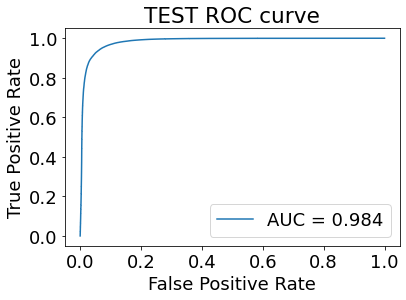

AUC: 0.984
Optimal threshold: 0.401
215400/215400 [==============================] - 73s 338us/sample - loss: 0.1762 - acc: 0.9354
TEST
Mouse 2
(215280, 50, 61)


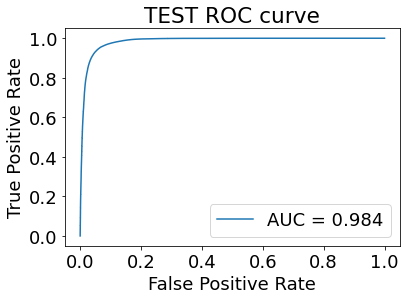

AUC: 0.984
Optimal threshold: 0.550
215280/215280 [==============================] - 83s 385us/sample - loss: 0.1448 - acc: 0.9480
TEST
Mouse 3
(251860, 50, 11)


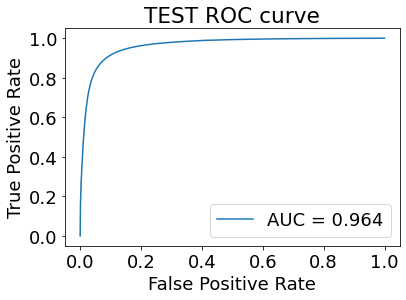

AUC: 0.964
Optimal threshold: 0.734
251860/251860 [==============================] - 61s 243us/sample - loss: 0.2335 - acc: 0.9098
TEST
Mouse 3
(251720, 50, 21)


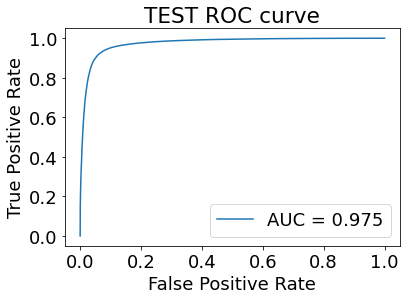

AUC: 0.975
Optimal threshold: 0.819
251720/251720 [==============================] - 55s 217us/sample - loss: 0.2083 - acc: 0.9213
TEST
Mouse 3
(251580, 50, 31)


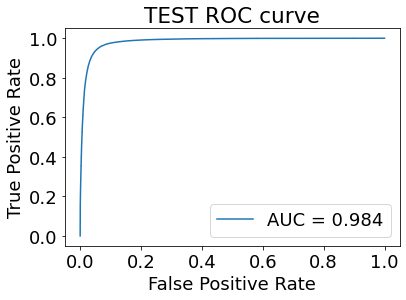

AUC: 0.984
Optimal threshold: 0.661
251580/251580 [==============================] - 62s 246us/sample - loss: 0.1499 - acc: 0.9492
TEST
Mouse 3
(251440, 50, 41)


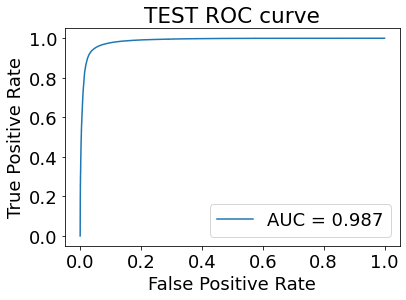

AUC: 0.987
Optimal threshold: 0.735
251440/251440 [==============================] - 74s 293us/sample - loss: 0.1336 - acc: 0.9520
TEST
Mouse 3
(251300, 50, 51)


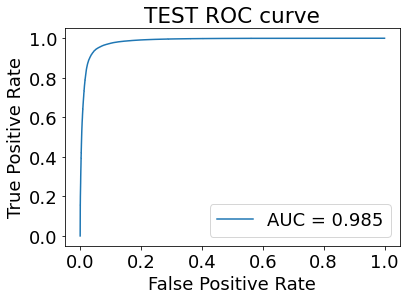

AUC: 0.985
Optimal threshold: 0.808
251300/251300 [==============================] - 86s 340us/sample - loss: 0.1484 - acc: 0.9464
TEST
Mouse 3
(251160, 50, 61)


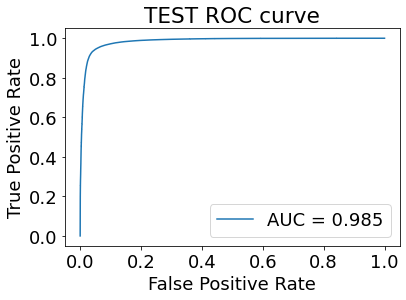

AUC: 0.985
Optimal threshold: 0.785
251160/251160 [==============================] - 97s 385us/sample - loss: 0.1481 - acc: 0.9447
TEST
Mouse 3
(251860, 50, 11)


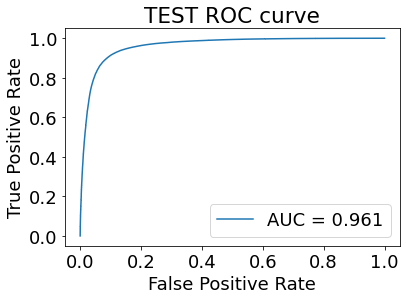

AUC: 0.961
Optimal threshold: 0.769
251860/251860 [==============================] - 59s 235us/sample - loss: 0.2408 - acc: 0.9064
TEST
Mouse 3
(251720, 50, 21)


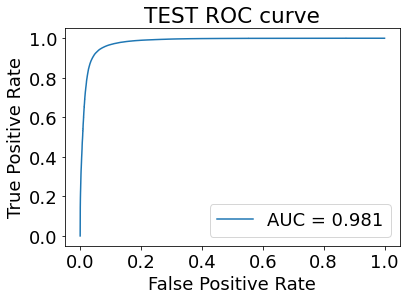

AUC: 0.981
Optimal threshold: 0.853
251720/251720 [==============================] - 59s 236us/sample - loss: 0.1731 - acc: 0.9375
TEST
Mouse 3
(251580, 50, 31)


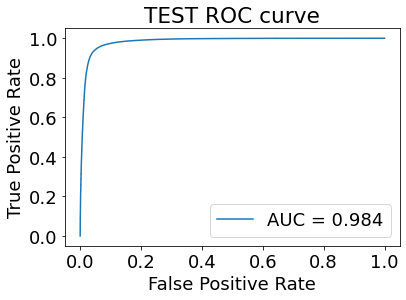

AUC: 0.984
Optimal threshold: 0.774
251580/251580 [==============================] - 65s 258us/sample - loss: 0.1478 - acc: 0.9471
TEST
Mouse 3
(251440, 50, 41)


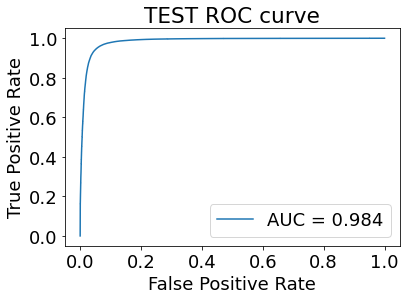

AUC: 0.984
Optimal threshold: 0.736
251440/251440 [==============================] - 74s 293us/sample - loss: 0.1409 - acc: 0.9511
TEST
Mouse 3
(251300, 50, 51)


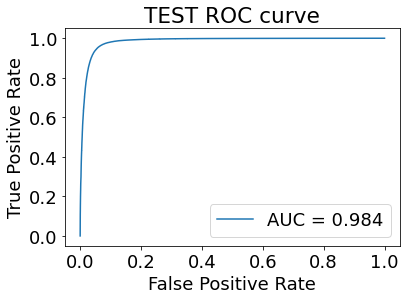

AUC: 0.984
Optimal threshold: 0.797
251300/251300 [==============================] - 87s 346us/sample - loss: 0.1464 - acc: 0.9506
TEST
Mouse 3
(251160, 50, 61)


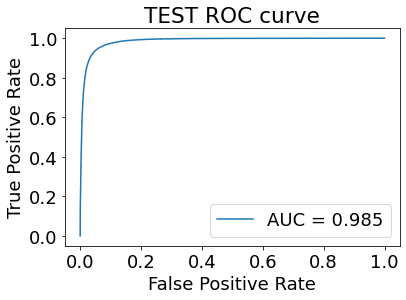

AUC: 0.985
Optimal threshold: 0.724
251160/251160 [==============================] - 99s 392us/sample - loss: 0.1417 - acc: 0.9485
TEST
Mouse 3
(251860, 50, 11)


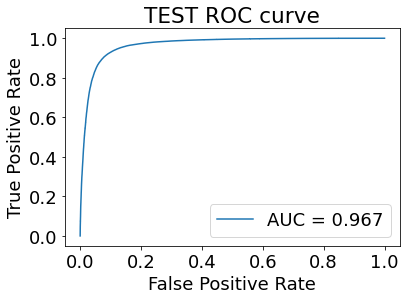

AUC: 0.967
Optimal threshold: 0.792
251860/251860 [==============================] - 55s 220us/sample - loss: 0.2264 - acc: 0.9149
TEST
Mouse 3
(251720, 50, 21)


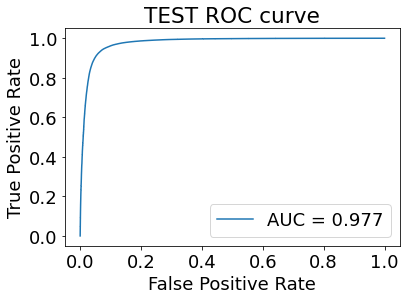

AUC: 0.977
Optimal threshold: 0.648
251720/251720 [==============================] - 57s 227us/sample - loss: 0.1720 - acc: 0.9398
TEST
Mouse 3
(251580, 50, 31)


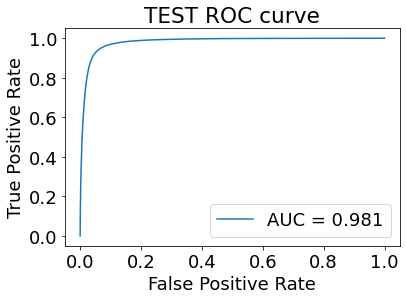

AUC: 0.981
Optimal threshold: 0.720
251580/251580 [==============================] - 64s 256us/sample - loss: 0.1580 - acc: 0.9448
TEST
Mouse 3
(251440, 50, 41)


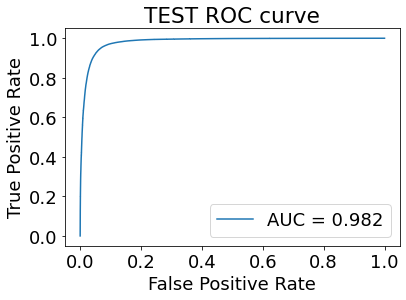

AUC: 0.982
Optimal threshold: 0.667
251440/251440 [==============================] - 76s 301us/sample - loss: 0.1534 - acc: 0.9471
TEST
Mouse 3
(251300, 50, 51)


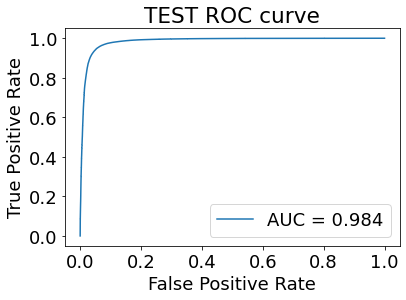

AUC: 0.984
Optimal threshold: 0.732
251300/251300 [==============================] - 88s 349us/sample - loss: 0.1455 - acc: 0.9494
TEST
Mouse 3
(251160, 50, 61)


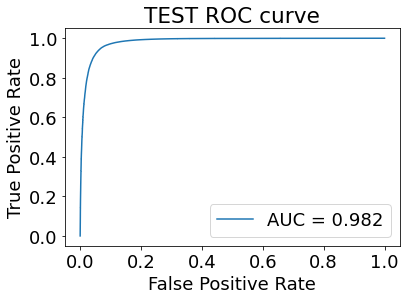

AUC: 0.982
Optimal threshold: 0.618
251160/251160 [==============================] - 98s 391us/sample - loss: 0.1513 - acc: 0.9468
TEST
Mouse 3
(251860, 50, 11)


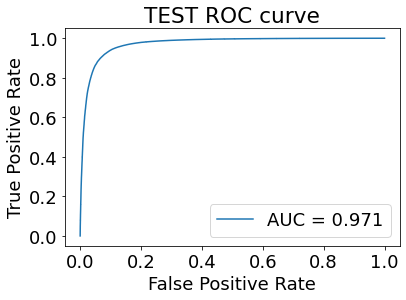

AUC: 0.971
Optimal threshold: 0.639
251860/251860 [==============================] - 57s 224us/sample - loss: 0.2011 - acc: 0.9267
TEST
Mouse 3
(251720, 50, 21)


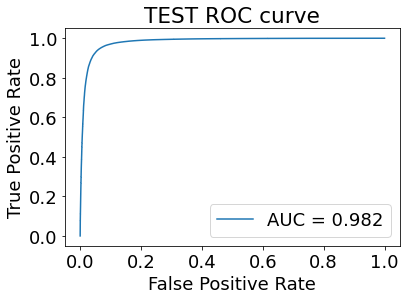

AUC: 0.982
Optimal threshold: 0.650
251720/251720 [==============================] - 59s 235us/sample - loss: 0.1563 - acc: 0.9461
TEST
Mouse 3
(251580, 50, 31)


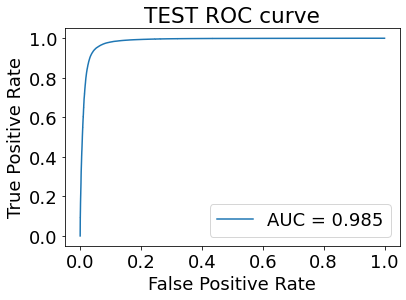

AUC: 0.985
Optimal threshold: 0.783
251580/251580 [==============================] - 69s 273us/sample - loss: 0.1385 - acc: 0.9529
TEST
Mouse 3
(251440, 50, 41)


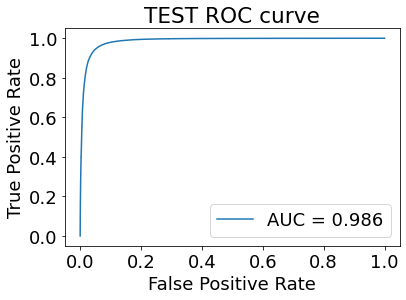

AUC: 0.986
Optimal threshold: 0.597
251440/251440 [==============================] - 75s 300us/sample - loss: 0.1341 - acc: 0.9528
TEST
Mouse 3
(251300, 50, 51)


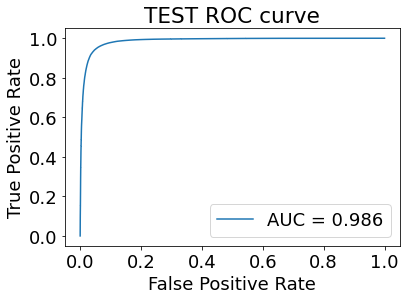

AUC: 0.986
Optimal threshold: 0.702
251300/251300 [==============================] - 88s 349us/sample - loss: 0.1356 - acc: 0.9517
TEST
Mouse 3
(251160, 50, 61)


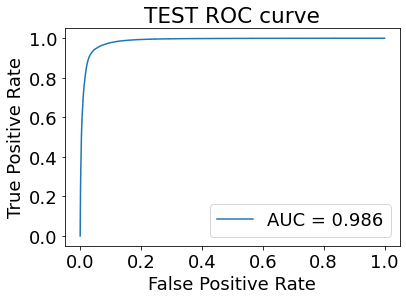

AUC: 0.986
Optimal threshold: 0.793
251160/251160 [==============================] - 100s 397us/sample - loss: 0.1369 - acc: 0.9505
TEST
Mouse 4
(269850, 50, 11)


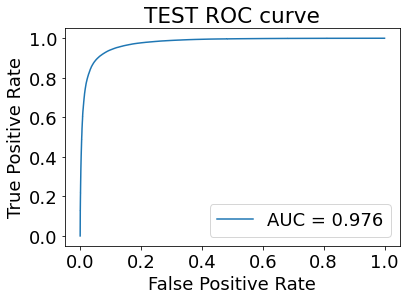

AUC: 0.976
Optimal threshold: 0.740
269850/269850 [==============================] - 63s 232us/sample - loss: 0.2061 - acc: 0.9222
TEST
Mouse 4
(269700, 50, 21)


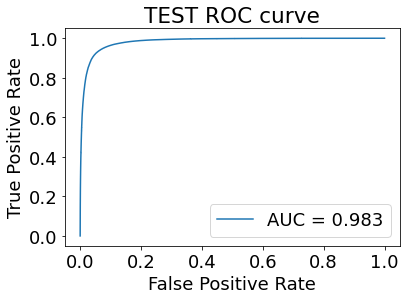

AUC: 0.983
Optimal threshold: 0.683
269700/269700 [==============================] - 65s 240us/sample - loss: 0.1686 - acc: 0.9381
TEST
Mouse 4
(269550, 50, 31)


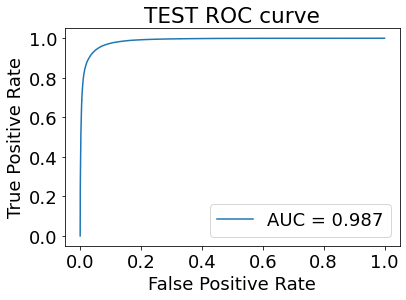

AUC: 0.987
Optimal threshold: 0.742
269550/269550 [==============================] - 72s 268us/sample - loss: 0.1507 - acc: 0.9456
TEST
Mouse 4
(269400, 50, 41)


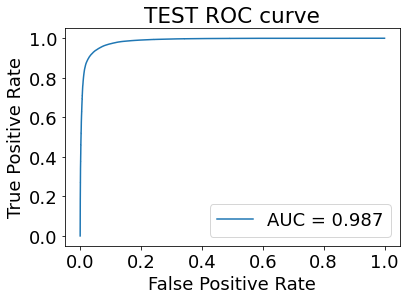

AUC: 0.987
Optimal threshold: 0.739
269400/269400 [==============================] - 83s 308us/sample - loss: 0.1498 - acc: 0.9450
TEST
Mouse 4
(269250, 50, 51)


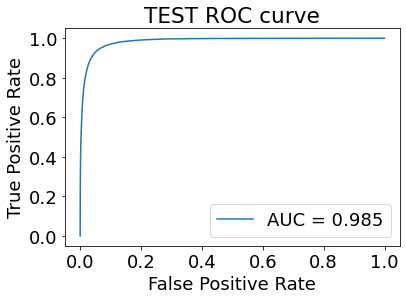

AUC: 0.985
Optimal threshold: 0.807
269250/269250 [==============================] - 95s 353us/sample - loss: 0.1664 - acc: 0.9383
TEST
Mouse 4
(269100, 50, 61)


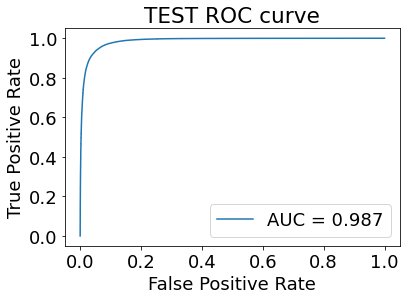

AUC: 0.987
Optimal threshold: 0.632
269100/269100 [==============================] - 107s 399us/sample - loss: 0.1473 - acc: 0.9459
TEST
Mouse 4
(269850, 50, 11)


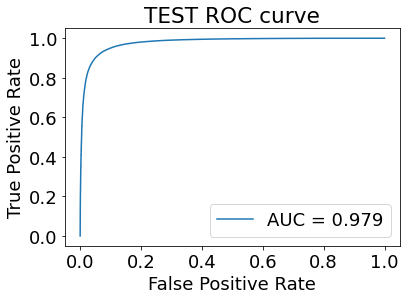

AUC: 0.979
Optimal threshold: 0.674
269850/269850 [==============================] - 56s 208us/sample - loss: 0.1879 - acc: 0.9281
TEST
Mouse 4
(269700, 50, 21)


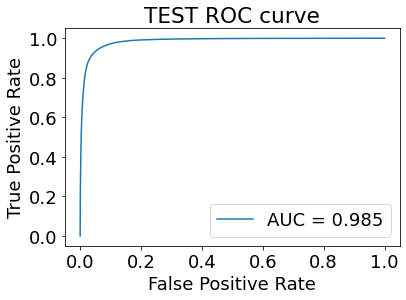

AUC: 0.985
Optimal threshold: 0.689
269700/269700 [==============================] - 61s 227us/sample - loss: 0.1537 - acc: 0.9437
TEST
Mouse 4
(269550, 50, 31)


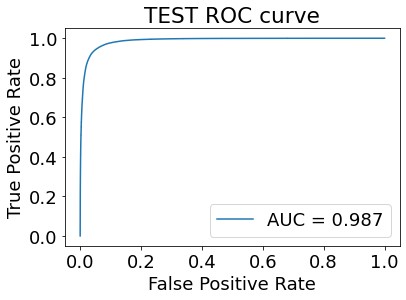

AUC: 0.987
Optimal threshold: 0.774
269550/269550 [==============================] - 73s 270us/sample - loss: 0.1470 - acc: 0.9460
TEST
Mouse 4
(269400, 50, 41)


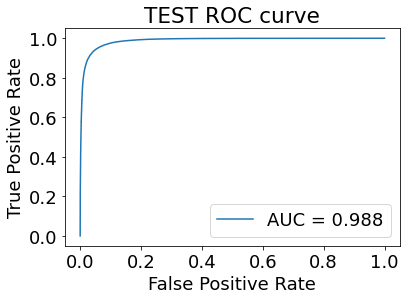

AUC: 0.988
Optimal threshold: 0.734
269400/269400 [==============================] - 84s 313us/sample - loss: 0.1425 - acc: 0.9465
TEST
Mouse 4
(269250, 50, 51)


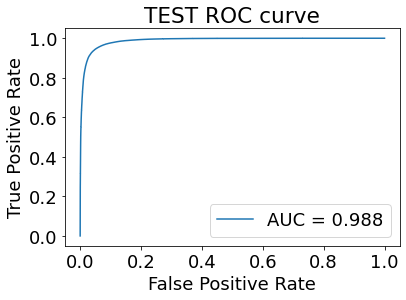

AUC: 0.988
Optimal threshold: 0.767
269250/269250 [==============================] - 96s 356us/sample - loss: 0.1420 - acc: 0.9463
TEST
Mouse 4
(269100, 50, 61)


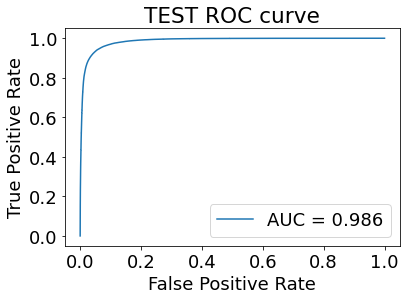

AUC: 0.986
Optimal threshold: 0.683
269100/269100 [==============================] - 108s 400us/sample - loss: 0.1499 - acc: 0.9431
TEST
Mouse 4
(269850, 50, 11)


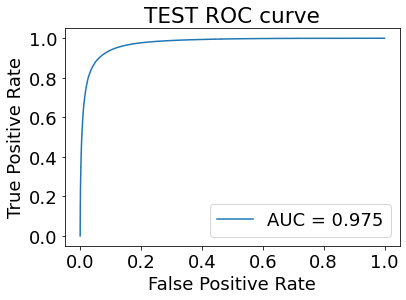

AUC: 0.975
Optimal threshold: 0.658
269850/269850 [==============================] - 61s 225us/sample - loss: 0.2054 - acc: 0.9226
TEST
Mouse 4
(269700, 50, 21)


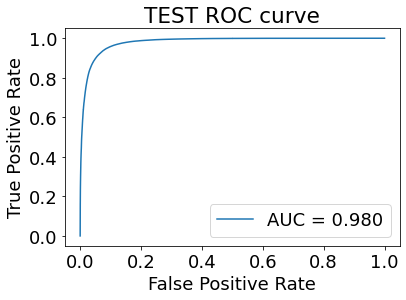

AUC: 0.980
Optimal threshold: 0.510
269700/269700 [==============================] - 64s 238us/sample - loss: 0.1804 - acc: 0.9332
TEST
Mouse 4
(269550, 50, 31)


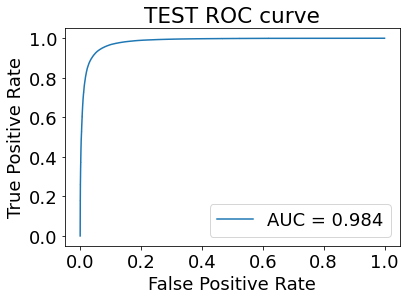

AUC: 0.984
Optimal threshold: 0.637
269550/269550 [==============================] - 74s 273us/sample - loss: 0.1593 - acc: 0.9408
TEST
Mouse 4
(269400, 50, 41)


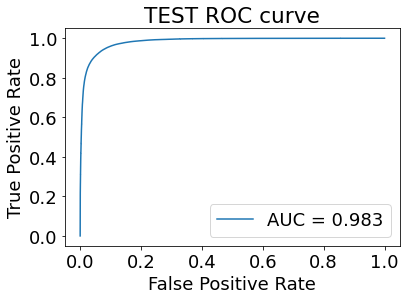

AUC: 0.983
Optimal threshold: 0.472
269400/269400 [==============================] - 84s 312us/sample - loss: 0.1786 - acc: 0.9337
TEST
Mouse 4
(269250, 50, 51)


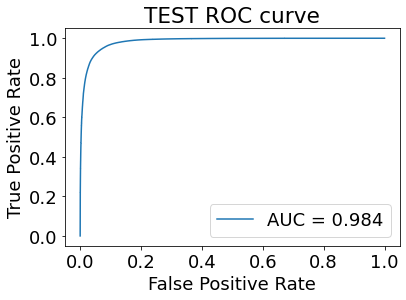

AUC: 0.984
Optimal threshold: 0.588
269250/269250 [==============================] - 96s 357us/sample - loss: 0.1559 - acc: 0.9404
TEST
Mouse 4
(269100, 50, 61)


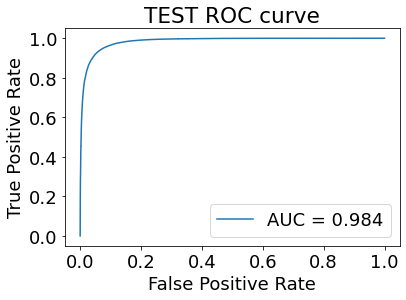

AUC: 0.984
Optimal threshold: 0.676
269100/269100 [==============================] - 109s 405us/sample - loss: 0.1606 - acc: 0.9385
TEST
Mouse 4
(269850, 50, 11)


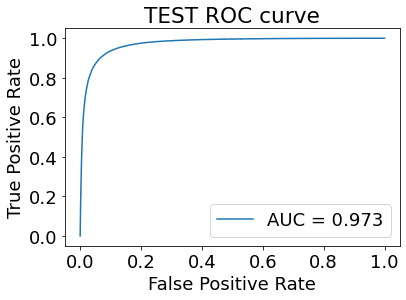

AUC: 0.973
Optimal threshold: 0.590
269850/269850 [==============================] - 56s 206us/sample - loss: 0.2160 - acc: 0.9207
TEST
Mouse 4
(269700, 50, 21)


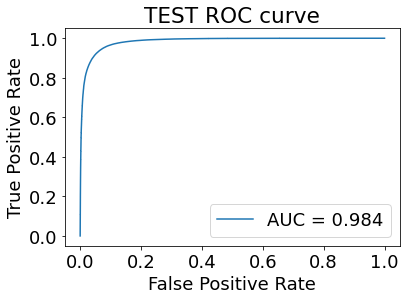

AUC: 0.984
Optimal threshold: 0.485
269700/269700 [==============================] - 70s 259us/sample - loss: 0.1626 - acc: 0.9387
TEST
Mouse 4
(269550, 50, 31)


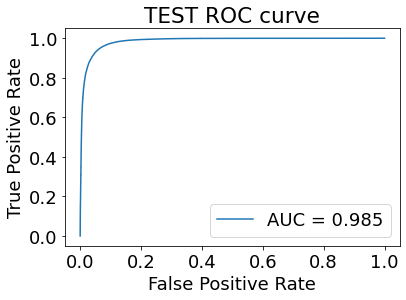

AUC: 0.985
Optimal threshold: 0.521
269550/269550 [==============================] - 75s 277us/sample - loss: 0.1481 - acc: 0.9444
TEST
Mouse 4
(269400, 50, 41)


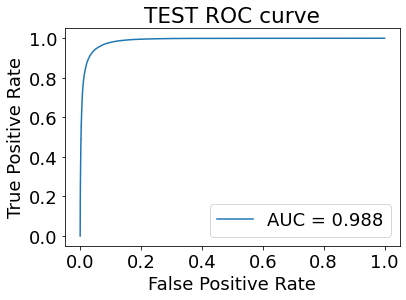

AUC: 0.988
Optimal threshold: 0.690
269400/269400 [==============================] - 86s 318us/sample - loss: 0.1376 - acc: 0.9491
TEST
Mouse 4
(269250, 50, 51)


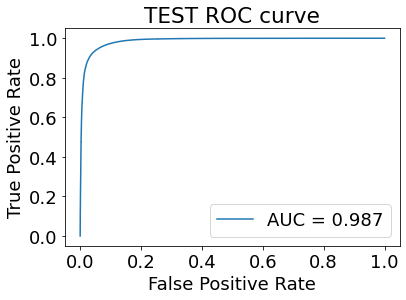

AUC: 0.987
Optimal threshold: 0.699
269250/269250 [==============================] - 98s 365us/sample - loss: 0.1431 - acc: 0.9451
TEST
Mouse 4
(269100, 50, 61)


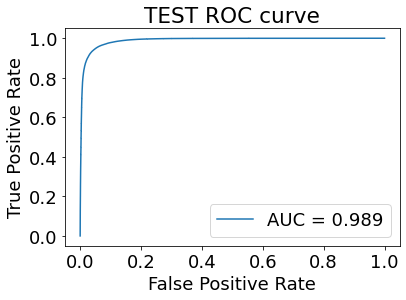

AUC: 0.989
Optimal threshold: 0.605
269100/269100 [==============================] - 112s 416us/sample - loss: 0.1330 - acc: 0.9502
TEST
Mouse 5
(215880, 50, 11)


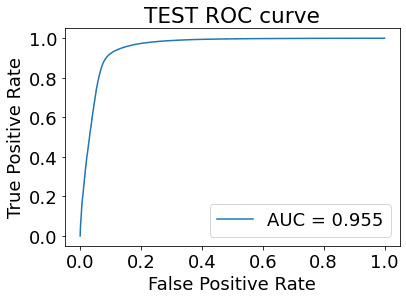

AUC: 0.955
Optimal threshold: 0.834
215880/215880 [==============================] - 46s 215us/sample - loss: 0.1840 - acc: 0.9381
TEST
Mouse 5
(215760, 50, 21)


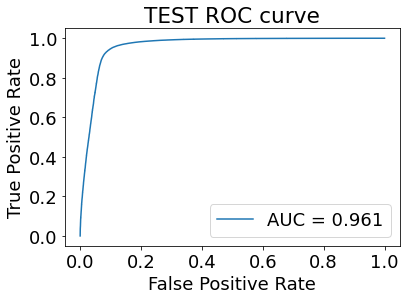

AUC: 0.961
Optimal threshold: 0.850
215760/215760 [==============================] - 56s 260us/sample - loss: 0.1672 - acc: 0.9460
TEST
Mouse 5
(215640, 50, 31)


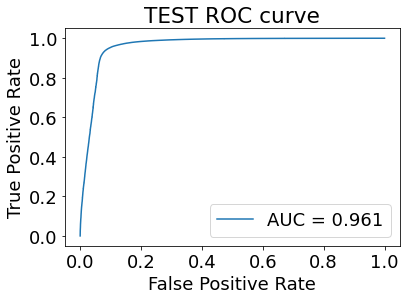

AUC: 0.961
Optimal threshold: 0.923
215640/215640 [==============================] - 63s 294us/sample - loss: 0.1754 - acc: 0.9421
TEST
Mouse 5
(215520, 50, 41)


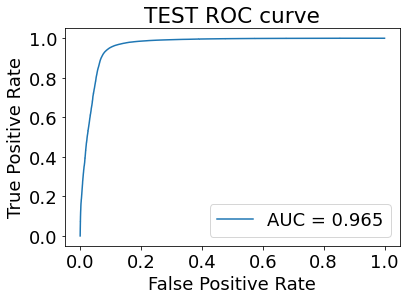

AUC: 0.965
Optimal threshold: 0.828
215520/215520 [==============================] - 70s 324us/sample - loss: 0.1608 - acc: 0.9514
TEST
Mouse 5
(215400, 50, 51)


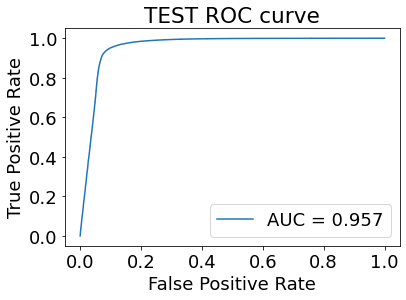

AUC: 0.957
Optimal threshold: 0.892
215400/215400 [==============================] - 81s 374us/sample - loss: 0.1654 - acc: 0.9487
TEST
Mouse 5
(215280, 50, 61)


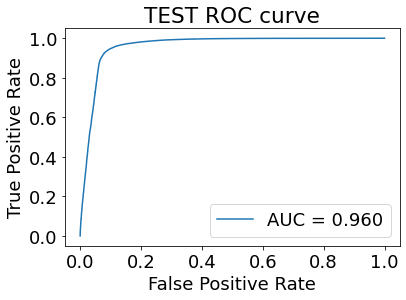

AUC: 0.960
Optimal threshold: 0.891
215280/215280 [==============================] - 90s 418us/sample - loss: 0.1712 - acc: 0.9463
TEST
Mouse 5
(215880, 50, 11)


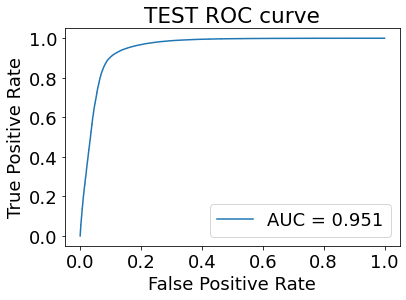

AUC: 0.951
Optimal threshold: 0.875
215880/215880 [==============================] - 44s 204us/sample - loss: 0.1926 - acc: 0.9354
TEST
Mouse 5
(215760, 50, 21)


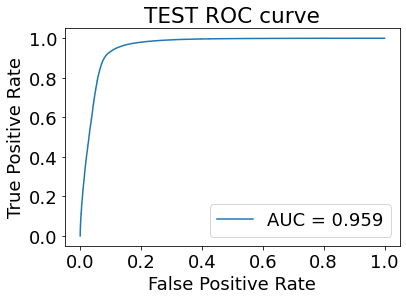

AUC: 0.959
Optimal threshold: 0.841
215760/215760 [==============================] - 57s 265us/sample - loss: 0.1674 - acc: 0.9445
TEST
Mouse 5
(215640, 50, 31)


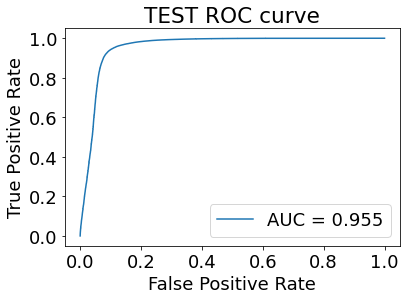

AUC: 0.955
Optimal threshold: 0.846
215640/215640 [==============================] - 64s 297us/sample - loss: 0.1665 - acc: 0.9480
TEST
Mouse 5
(215520, 50, 41)


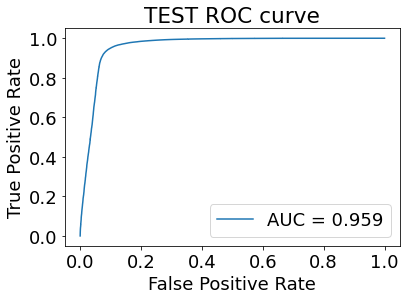

AUC: 0.959
Optimal threshold: 0.893
215520/215520 [==============================] - 72s 333us/sample - loss: 0.1655 - acc: 0.9485
TEST
Mouse 5
(215400, 50, 51)


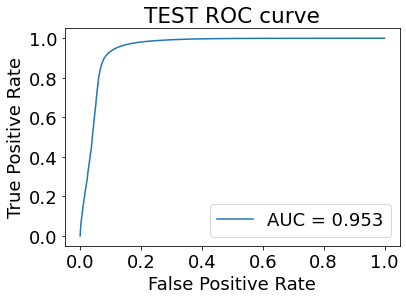

AUC: 0.953
Optimal threshold: 0.853
215400/215400 [==============================] - 82s 382us/sample - loss: 0.1759 - acc: 0.9460
TEST
Mouse 5
(215280, 50, 61)


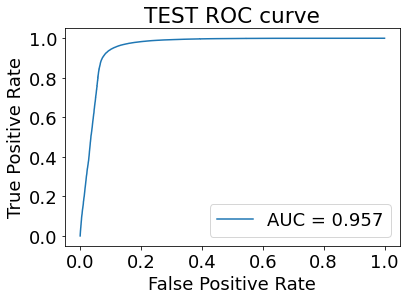

AUC: 0.957
Optimal threshold: 0.891
215280/215280 [==============================] - 90s 420us/sample - loss: 0.1691 - acc: 0.9473
TEST
Mouse 5
(215880, 50, 11)


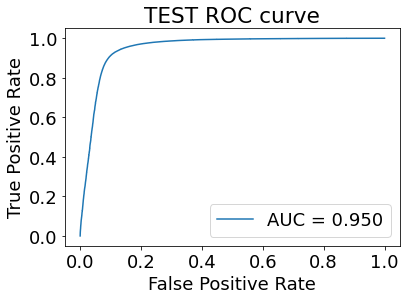

AUC: 0.950
Optimal threshold: 0.798
215880/215880 [==============================] - 44s 206us/sample - loss: 0.1927 - acc: 0.9376
TEST
Mouse 5
(215760, 50, 21)


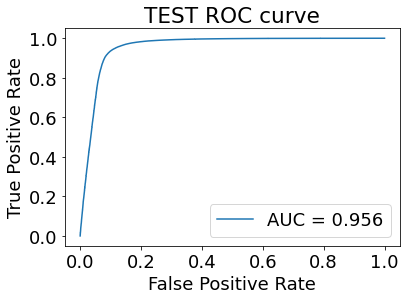

AUC: 0.956
Optimal threshold: 0.697
215760/215760 [==============================] - 59s 272us/sample - loss: 0.1714 - acc: 0.9462
TEST
Mouse 5
(215640, 50, 31)


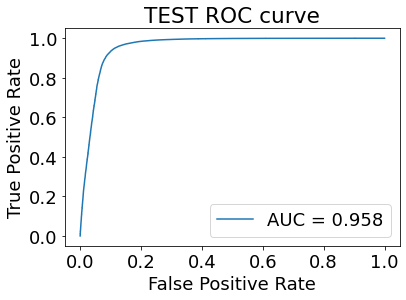

AUC: 0.958
Optimal threshold: 0.739
215640/215640 [==============================] - 65s 300us/sample - loss: 0.1659 - acc: 0.9481
TEST
Mouse 5
(215520, 50, 41)


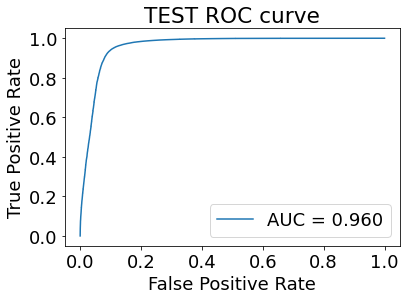

AUC: 0.960
Optimal threshold: 0.780
215520/215520 [==============================] - 71s 329us/sample - loss: 0.1638 - acc: 0.9488
TEST
Mouse 5
(215400, 50, 51)


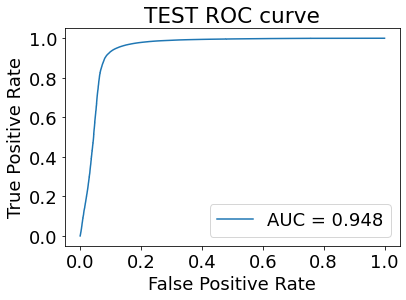

AUC: 0.948
Optimal threshold: 0.754
215400/215400 [==============================] - 81s 375us/sample - loss: 0.1835 - acc: 0.9442
TEST
Mouse 5
(215280, 50, 61)


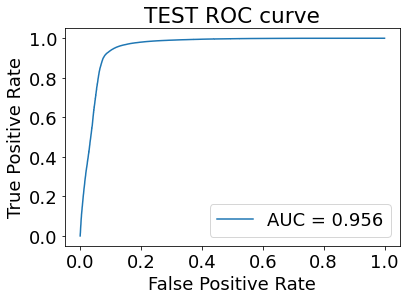

AUC: 0.956
Optimal threshold: 0.792
215280/215280 [==============================] - 91s 423us/sample - loss: 0.1737 - acc: 0.9456
TEST
Mouse 5
(215880, 50, 11)


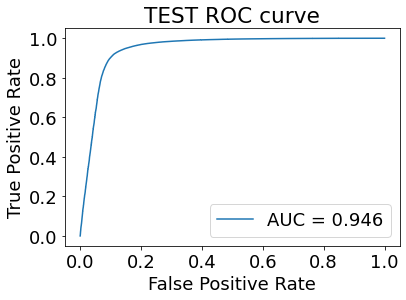

AUC: 0.946
Optimal threshold: 0.871
215880/215880 [==============================] - 44s 202us/sample - loss: 0.2068 - acc: 0.9287
TEST
Mouse 5
(215760, 50, 21)


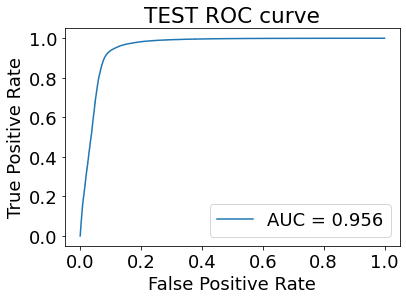

AUC: 0.956
Optimal threshold: 0.893
215760/215760 [==============================] - 59s 273us/sample - loss: 0.1785 - acc: 0.9429
TEST
Mouse 5
(215640, 50, 31)


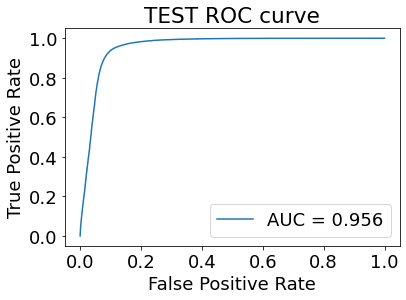

AUC: 0.956
Optimal threshold: 0.803
215640/215640 [==============================] - 65s 300us/sample - loss: 0.1661 - acc: 0.9473
TEST
Mouse 5
(215520, 50, 41)


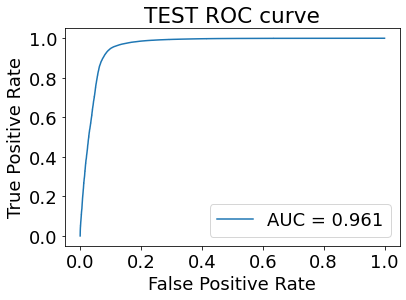

AUC: 0.961
Optimal threshold: 0.820
215520/215520 [==============================] - 73s 338us/sample - loss: 0.1582 - acc: 0.9503
TEST
Mouse 5
(215400, 50, 51)


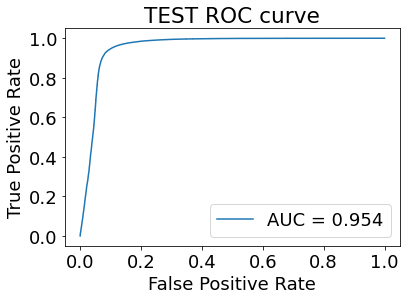

AUC: 0.954
Optimal threshold: 0.895
215400/215400 [==============================] - 84s 389us/sample - loss: 0.1716 - acc: 0.9483
TEST
Mouse 5
(215280, 50, 61)


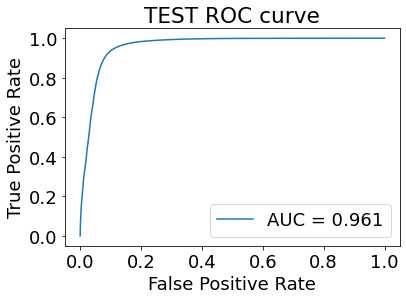

AUC: 0.961
Optimal threshold: 0.845
215280/215280 [==============================] - 92s 426us/sample - loss: 0.1640 - acc: 0.9476


In [14]:
l = [1, 2, 3, 4, 5]
for raw, v in enumerate(itertools.permutations(l, 2)):
    TEST = [v[0]]
    VALID = [v[1]]
    df_AUC['TEST'][raw] = df_LOSS['TEST'][raw] = df_ACC['TEST'][raw] = v[0]
    df_AUC['VALID'][raw] = df_LOSS['VALID'][raw] = df_ACC['VALID'][raw] = v[1]
    for look_frame in LookFrame:
        testX, testY = Get_Dataset(TEST, look_frame)
        print(testX.shape)
        input_test = testX.transpose(0,2,1)
        ver = f'{ModelType}_{VALID}_{TEST}_{look_frame}'
        model_file_path = f'./models_N20_WindowExpand/{ModelType}/best_model_{ver}.h5'
        model = load_model(model_file_path)
        test_pred = model.predict(input_test)
        df_AUC[look_frame][raw] = plot_roc(test_pred, testY, "TEST")
        results = model.evaluate(input_test,testY)
        df_LOSS[look_frame][raw] = results[0]
        df_ACC[look_frame][raw] = results[1]

In [15]:
df_AUC.to_csv('N20_WindowExpand_result_AUC.csv')
df_AUC

,VALID,TEST,5,10,15,20,25,30
0,2.0,1.0,0.904444,0.951685,0.958076,0.964026,0.947703,0.959086
1,3.0,1.0,0.869181,0.940101,0.955052,0.963247,0.963700,0.968185
2,4.0,1.0,0.885148,0.944417,0.960126,0.961678,0.967101,0.966347
3,5.0,1.0,0.916641,0.950747,0.958905,0.963952,0.966753,0.970844
4,1.0,2.0,0.962049,0.982116,0.986540,0.984458,0.963577,0.972381
5,3.0,2.0,0.958952,0.981677,0.985850,0.986471,0.983275,0.987341
6,4.0,2.0,0.960260,0.980068,0.981014,0.986593,0.987082,0.984544
7,5.0,2.0,0.959890,0.980851,0.982591,0.987256,0.983573,0.984217
8,1.0,3.0,0.963850,0.974726,0.983654,0.987034,0.985005,0.984993
9,2.0,3.0,0.961424,0.981322,0.983640,0.984382,0.984005,0.985474


In [16]:
df_LOSS.to_csv('N20_WindowExpand_result_BCEloss.csv')
df_LOSS

,VALID,TEST,5,10,15,20,25,30
0,2.0,1.0,0.385465,0.339279,0.255329,0.261426,0.307737,0.274665
1,3.0,1.0,0.469203,0.357470,0.336411,0.322795,0.273253,0.249911
2,4.0,1.0,0.440960,0.338105,0.326430,0.318981,0.262879,0.266784
3,5.0,1.0,0.366514,0.375013,0.344918,0.325146,0.277054,0.254099
4,1.0,2.0,0.285602,0.158711,0.144285,0.144186,0.258127,0.222254
5,3.0,2.0,0.359329,0.186606,0.162489,0.145333,0.169628,0.130841
6,4.0,2.0,0.353761,0.197589,0.194369,0.145064,0.133606,0.150497
7,5.0,2.0,0.310838,0.177355,0.171304,0.155967,0.176181,0.144791
8,1.0,3.0,0.233532,0.208327,0.149898,0.133637,0.148389,0.148094
9,2.0,3.0,0.240849,0.173070,0.147848,0.140896,0.146402,0.141663


In [17]:
df_ACC.to_csv('N20_WindowExpand_result_Accuracy.csv')
df_ACC

,VALID,TEST,5,10,15,20,25,30
0,2.0,1.0,0.833311,0.849378,0.891395,0.885280,0.879802,0.891482
1,3.0,1.0,0.802875,0.851193,0.853119,0.863591,0.883429,0.891968
2,4.0,1.0,0.813452,0.852993,0.855937,0.862639,0.890094,0.883997
3,5.0,1.0,0.842347,0.832420,0.852390,0.871927,0.875989,0.891725
4,1.0,2.0,0.888086,0.943915,0.948456,0.946998,0.905998,0.913573
5,3.0,2.0,0.856207,0.927021,0.940442,0.946808,0.939387,0.950125
6,4.0,2.0,0.856198,0.926112,0.923933,0.945597,0.948798,0.946349
7,5.0,2.0,0.881911,0.933950,0.935318,0.942196,0.935446,0.948007
8,1.0,3.0,0.909815,0.921270,0.949229,0.951997,0.946355,0.944653
9,2.0,3.0,0.906396,0.937518,0.947118,0.951074,0.950645,0.948479
